In [4]:
from omegaconf import OmegaConf
import yaml
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
from tqdm import tqdm

In [5]:
key_2_name = {
    0: "NOOP",
    1: "Fire",
    2: "Up",
    3: "Right",
    4: "Left",
    5: "Down",
    6: "Up-Right",
    7: "Up-Left",
    8: "Down-Right",
    9: "Down-Left",
    10: "Fire-Up",
    11: "Fire-Right",
    12: "Fire-Left",
    13: "Fire-Down",
    14: "Fire-Up-Right",
    15: "Fire-Up-Left",
    16: "Fire-Down-Right",
    17: "Fire-Down-Left"
}

# Dataset

In [6]:
from supersuit import frame_skip_v0, resize_v1
import numpy as np

def get_env_from_id(id: str):
    if id == "boxing":
        from pettingzoo.atari import boxing_v2
        return boxing_v2.parallel_env
    
    else:
        raise ValueError(f"Environment {id} not found")

def env_fn(env_func):
    env = env_func(render_mode="rgb_array")
    env = frame_skip_v0(env, num_frames=4)
    env = resize_v1(env, x_size=64, y_size=64)

    return env

def env_loop(env_func):
    env = env_fn(env_func=env_func)
    observations, infos = env.reset()

    def get_random_action():
        actions_list = list(range(18))
        random.shuffle(actions_list)

        jitter = 0.1

        _actions = []
        for action in actions_list:
            _actions.extend([action] * random.randint(4, 10))
            _actions.extend([0] * random.randint(1, 5))

        for i in range(len(_actions)):
            if random.random() < jitter:
                _actions.insert(i, random.randint(0, 17))

        actions_list = _actions
        return actions_list

    actions_dict = {
        "first_0": get_random_action(),
        "second_0": get_random_action()
    }

    current = 0

    while env.agents:
        actions = {}
        for agent in env.agents:
            if current >= len(actions_dict[agent]):
                current = 0
                actions_dict = {
                    "first_0": get_random_action(),
                    "second_0": get_random_action()
                }
            
            actions[agent] = actions_dict[agent][current]
            current += 1

        observations, *_ = env.step(actions)
        yield observations, actions
    env.close()

In [7]:
import random
import torch

class AtariDataset(Dataset):
    def __init__(self, seq_length: int, sequence_per_episode: int = 500):
        self.seq_length = seq_length
        self.dataset = []
        self.sequence_per_episode = sequence_per_episode

    def __len__(self):
        if len(self.dataset) == 0:
            return 0
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if self.dataset is None or len(self.dataset) == 0:
            return None
        
        frames = self.dataset[idx]['frames']
        prev_actions = self.dataset[idx]['prev_actions']

        return frames, prev_actions

    def reset(self, percent: float = 0.1):
        if len(self.dataset) == 0:
            return

        keep = int(len(self.dataset) * percent)
        random.shuffle(self.dataset)

        self.dataset = self.dataset[:keep]
    
    def _to_tensor(self, x):
        return torch.tensor(x, device='cuda').div(255).mul(2).sub(1).permute(0, 3, 1, 2).contiguous()
    
    def collect_dataset(self, env_loop_func, episodes:int=1000, progress_bar:bool=False):
        if progress_bar:
            pbar = tqdm(total=episodes)
        else:
            pbar = None

        for _ in range(episodes):
            if pbar is not None:
                pbar.update(1)
            env_loop = iter(env_loop_func()) 

            frames = []
            prev_actions = [[], []]

            current = 0
            num_appended = 0
            random_start = random.randint(0, 64)

            for observations, actions in env_loop:
                if num_appended >= self.sequence_per_episode:
                    break

                if len(frames) == 0 and random.random() < 0.65:
                    current += 1
                    continue
                
                if current < random_start:
                    current += 1
                    continue

                frames.append(observations['first_0'])

                prev_actions[0].append(actions['first_0'])
                prev_actions[1].append(actions['second_0'])

                if len(frames) >= self.seq_length:
                    self.dataset.append({
                        'frames': self._to_tensor(frames),
                        'prev_actions': torch.tensor(prev_actions, dtype=torch.long)
                    })
                    
                    frames = []
                    prev_actions = [[], []]

                    num_appended += 1
                current += 1

Visualize the dataset.

In [11]:
from tqdm import tqdm

train_dataset = AtariDataset(seq_length=6, sequence_per_episode=100)
train_dataset.collect_dataset(
    lambda: env_loop(env_func=get_env_from_id("boxing")),
    episodes=5,
    progress_bar=True
)

iters = iter(train_dataset)
















100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


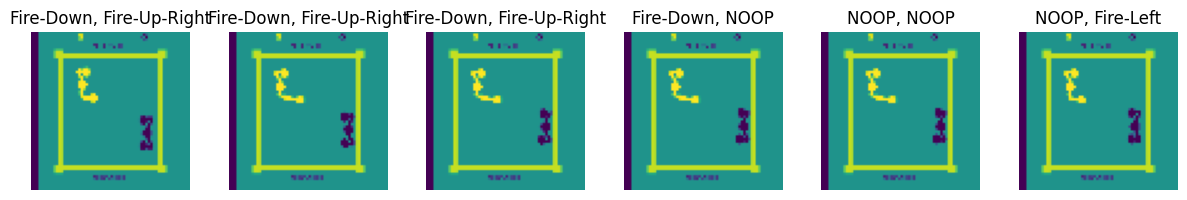

In [14]:
data = next(iters)
print()

fig, axs = plt.subplots(1, 6, figsize=(6 * 2, 2))
for i in range(6):
    axs[i].imshow(data[0][i][0].cpu().numpy())
    axs[i].set_title(f"{key_2_name[data[1][0][i].item()]}, {key_2_name[data[1][1][i].item()]}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

# MODEL

In [ ]:
from models.diffusion.denoiser import Denoiser
from models.diffusion import DiffusionSampler, DiffusionSamplerConfig

In [ ]:
with open("/home/monsh/works/image/madx/config/trainer.yaml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg['agent']['denoiser']['inner_model']['num_actions'] = 18 # Number of actions in the environment.
    cfg['agent']['denoiser']['inner_model']['cond_channels'] = 768 # Adjusted condition channels.

cfg = OmegaConf.structured(cfg)

cfg['optimizer']['lr'] = 1e-4
cfg['training']['lr_warmup_steps'] = 100

denoiser = Denoiser(cfg.agent.denoiser).to("cuda:0")
denoiser.setup_training(OmegaConf.structured(cfg.agent.denoiser.sigma_distribution))

/home/monsh/anaconda3/envs/madx/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Training

In [9]:
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from tqdm import tqdm

def process_image(tensor):
    img = Image.fromarray(tensor.add(1).div(2).mul(255).byte().permute(1, 2, 0).cpu().numpy())
    pygame_image = np.array(img.resize((64, 64), resample=Image.NEAREST)) #.transpose((1, 0, 2))
    return pygame_image

game_id = "boxing"
batch_size = 32

opt = torch.optim.AdamW(
    denoiser.parameters(),
    lr=1e-4,
    weight_decay=1e-2,
)
# lr_sched = build_lr_sched(opt, cfg)

lr_sched = lr_scheduler.CosineAnnealingWarmRestarts(
    opt,
    T_0=5,
    T_mult=1,
    eta_min=1e-5,
)

save_every = 5
exp_name = "attention"

In [ ]:
max_epochs = 300


train_dataset = AtariDataset(seq_length=6, sequence_per_episode=100)
for epoch in range(max_epochs):
    denoiser.train()

    if epoch % save_every == 0:

        train_dataset.reset(percent=0.75)
        train_dataset.collect_dataset(
            lambda: env_loop(env_func=get_env_from_id(game_id)),
            episodes=25 if epoch > 0 else 100,
            progress_bar=True
        )
        dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    with tqdm(total=len(dataloader)) as pbar:
        desc = f"Epoch {epoch}"
        pbar.update(0)

        for i, (frames, prev_actions) in enumerate(dataloader):
            frames = frames.to("cuda:0")
            prev_actions = prev_actions.to("cuda:0")

            loss, logs = denoiser(prev_actions, frames)
            opt.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(denoiser.parameters(), cfg.training.max_grad_norm)
            opt.step()
            lr_sched.step()

            pbar.set_description(desc)
            pbar.set_postfix(loss=loss.item(), **logs)
    
    # Evaluate the model every `save_every` epochs.
    if epoch % save_every == 0:
        denoiser.eval()
        with torch.no_grad():
            sampler = DiffusionSampler(
                denoiser=denoiser,
                cfg=DiffusionSamplerConfig(
                    num_steps_denoising=3
                ),
            )
            
            test_dataset = AtariDataset(seq_length=12, sequence_per_episode=20)
            test_dataset.collect_dataset(
                lambda: env_loop(env_func=get_env_from_id("boxing")),
                episodes=1,
                progress_bar=False
            )
            test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
            iters = iter(test_dataloader)
            data = next(iters)

            step = 8
            seq = 4
            current_frame = 0
            frames, actions = next(iters)
            frames = frames.squeeze(0)
            actions = actions.squeeze(0)
            
            # Reduce the number of frames to 4
            frames = frames[current_frame: current_frame + seq]

            n = step - frames.shape[0]
            images = [process_image(frame) for frame in frames]

            for current_frame in tqdm(range(n)):
                _frames = frames[current_frame: current_frame + seq]
                _actions = actions[:, current_frame: current_frame + seq]
                out = sampler.sample(_frames.unsqueeze(0).to("cuda"), _actions.unsqueeze(0).to("cuda"))

                frames = torch.cat([frames, out[0]], dim=0)

                image = process_image(out[0][0])
                images.append(image)
            
            fig, axs = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
            for i, image in enumerate(images):
                axs[i].imshow(image)
                axs[i].set_title(f"{key_2_name[actions[0][i].item()]}, {key_2_name[actions[1][i].item()]}")

                axs[i].axis("off")
            plt.tight_layout()
            plt.show()

        torch.save(denoiser.state_dict(), f"denoiser_{exp_name}_{epoch}.pt")
torch.save(denoiser.state_dict(), f"denoiser_{exp_name}_{max_epochs}.pt")